In [1]:
from docplex.mp.model import Model
from enum import Enum
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")

# Data, Classes, Methods definitions

In [2]:
class Tutoring(Enum):
    NORMAL = 1
    EXTENSIVE = 2
class TuitionCentre(Enum):
    NORTH = 1
    SOUTH = 2
    EAST = 3
    WEST = 4
    CENTRAL = 5
# Type A: min tutors. Type B: balance workload
class ObjectiveType(Enum):
    A = 1
    B = 2

In [3]:
class Student:
    def __init__(self, student_id, tutoring, centre):
        self.id = student_id
        self.tutoring = tutoring
        self.centre = centre

class Tutor:
    def __init__(self, tutor_id, tutoring, preferred_centre, preferred_centre2, capacity):
        self.id = tutor_id
        self.tutoring = tutoring
        self.preferred_centre = preferred_centre
        self.preferred_centre2 = preferred_centre2
        self.capacity = capacity
        self.assigned_students = None

class Problem:
    def __init__(self, objective_type, preference_lb, preference_ub):
        # combine new with active existing students
        self.students = [
            Student('S0001',Tutoring.NORMAL,TuitionCentre.EAST),
            Student('S0002',Tutoring.NORMAL,TuitionCentre.WEST),
            Student('S0003',Tutoring.NORMAL,TuitionCentre.CENTRAL),
            Student('S0004',Tutoring.NORMAL,TuitionCentre.EAST),
            Student('S0005',Tutoring.NORMAL,TuitionCentre.CENTRAL),
            Student('S0006',Tutoring.EXTENSIVE,TuitionCentre.NORTH),
            Student('S0007',Tutoring.NORMAL,TuitionCentre.EAST),
            Student('S0008',Tutoring.NORMAL,TuitionCentre.CENTRAL),
            Student('S0009',Tutoring.NORMAL,TuitionCentre.NORTH),
            Student('S0010',Tutoring.NORMAL,TuitionCentre.WEST),
            Student('S0011',Tutoring.EXTENSIVE,TuitionCentre.CENTRAL),
            Student('S0012',Tutoring.NORMAL,TuitionCentre.WEST),
            Student('S0013',Tutoring.NORMAL,TuitionCentre.WEST),
            Student('S0014',Tutoring.NORMAL,TuitionCentre.NORTH),
            Student('S0015',Tutoring.NORMAL,TuitionCentre.EAST),
            Student('S0016',Tutoring.NORMAL,TuitionCentre.NORTH),
            Student('S0017',Tutoring.NORMAL,TuitionCentre.NORTH),
            Student('S0018',Tutoring.NORMAL,TuitionCentre.WEST),
            Student('S0019',Tutoring.NORMAL,TuitionCentre.WEST),
            Student('S0020',Tutoring.NORMAL,TuitionCentre.NORTH),
            Student('S0036',Tutoring.NORMAL,TuitionCentre.CENTRAL),
            Student('S0057',Tutoring.NORMAL,TuitionCentre.EAST),
            Student('S0059',Tutoring.NORMAL,TuitionCentre.CENTRAL),
            Student('S0061',Tutoring.NORMAL,TuitionCentre.CENTRAL),
            Student('S0062',Tutoring.NORMAL,TuitionCentre.CENTRAL),
            Student('S0086',Tutoring.EXTENSIVE,TuitionCentre.CENTRAL),
            Student('S0088',Tutoring.NORMAL,TuitionCentre.CENTRAL),
            Student('S0091',Tutoring.NORMAL,TuitionCentre.WEST),
            Student('S0092',Tutoring.NORMAL,TuitionCentre.CENTRAL),
            Student('S0093',Tutoring.EXTENSIVE,TuitionCentre.CENTRAL),
            Student('S0110',Tutoring.NORMAL,TuitionCentre.CENTRAL),
            Student('S0119',Tutoring.NORMAL,TuitionCentre.EAST)

        ]
        self.tutors = [
            Tutor('A001', Tutoring.EXTENSIVE, TuitionCentre.EAST, TuitionCentre.NORTH, 8), 
            Tutor('A002', Tutoring.NORMAL, TuitionCentre.NORTH, TuitionCentre.EAST, 5), 
            Tutor('A003', Tutoring.NORMAL, TuitionCentre.WEST, TuitionCentre.NORTH, 5), 
            Tutor('A004', Tutoring.NORMAL, TuitionCentre.NORTH, TuitionCentre.EAST, 3), 
            Tutor('A005', Tutoring.NORMAL, TuitionCentre.NORTH, TuitionCentre.CENTRAL, 6), 
            Tutor('A006', Tutoring.EXTENSIVE, TuitionCentre.EAST, TuitionCentre.CENTRAL, 5), 
            Tutor('A007', Tutoring.NORMAL, TuitionCentre.EAST, TuitionCentre.NORTH, 8), 
            Tutor('A008', Tutoring.NORMAL, TuitionCentre.CENTRAL, TuitionCentre.WEST, 5), 
            Tutor('A009', Tutoring.EXTENSIVE, TuitionCentre.CENTRAL, TuitionCentre.NORTH, 4), 
            Tutor('A010', Tutoring.NORMAL, TuitionCentre.WEST, TuitionCentre.NORTH, 8)
        ]
        self.students_dict = dict([(s.id, s) for s in self.students])
        self.tutors_dict = dict([(t.id, t) for t in self.tutors])
        
        m = Model(name="Optimizing Tuition Assignments")
        
        # create decision variables
        self.d_tutor_student = {}
        self.d_student_tutor = {}
        for tutor in self.tutors:
            self.d_tutor_student[tutor.id] = {}
            for student in self.students:
                bin_var = m.binary_var(f"{tutor.id}_{student.id}")
                self.d_tutor_student[tutor.id][student.id] = bin_var
                if student.id not in self.d_student_tutor:
                    self.d_student_tutor[student.id] = {}
                self.d_student_tutor[student.id][tutor.id] = bin_var
        self.d_tutor_centre = {}
        for tutor in self.tutors:
            self.d_tutor_centre[tutor.id] = {}
            for centre in TuitionCentre:
                self.d_tutor_centre[tutor.id][centre] = m.binary_var(f"{tutor.id}_{centre.name}")

        # define constraints
        #    tutor's capacity cannot be exceeded
        for tutor_id, d_tutor_students in self.d_tutor_student.items():
            tutor = self.tutors_dict[tutor_id]
            m.add_constraint(m.sum(d_tutor_students.values()) <= tutor.capacity)
        #    tutor cannot be assigned to more than one centre
        for d_tutor_centres in self.d_tutor_centre.values():
            m.add_constraint(m.sum(d_tutor_centres.values()) <= 1)
        #    tutor must not be assigned to student from another centre
        for tutor in self.tutors:
            for student in self.students:
                m.add_constraint(self.d_tutor_centre[tutor.id][student.centre] - self.d_tutor_student[tutor.id][student.id] >= 0)
        #    tutor's and student's skill must be appropriate
        for tutor in self.tutors:
            for student in self.students:
                if (student.tutoring == Tutoring.EXTENSIVE and tutor.tutoring == Tutoring.NORMAL):
                    m.add_constraint(self.d_tutor_student[tutor.id][student.id] == 0)
        #    student can only have one tutor
        for d_student_tutors in self.d_student_tutor.values():
            m.add_constraint(m.sum(d_student_tutors.values()) == 1)
        #    average preference score must be within bounds
        #    add points for preference: 0 for not in preferences, 1 for second preference, 2 for first preference   
        preference_score = 0
        for tutor in self.tutors:
            for centre in TuitionCentre:
                points = 0
                if centre == tutor.preferred_centre:
                    points = 2
                elif centre == tutor.preferred_centre2:
                    points = 1
                else:
                    continue
                preference_score += self.d_tutor_centre[tutor.id][centre] * points
        preference_score = preference_score / len(self.tutors)
        self.preference_score = m.continuous_var(name="preference_score")
        m.add_constraint(self.preference_score == preference_score)
        m.add_constraint(self.preference_score >= preference_lb)
        m.add_constraint(self.preference_score <= preference_ub)

        # define objective
        obj = 0
        #     minimize # of tutors assigned
        if objective_type == ObjectiveType.A:
            obj += m.sum([d for d_tutor_centres in self.d_tutor_centre.values() for d in d_tutor_centres.values()])
        #     balance workload of tutors using mean absolute deviation
        if objective_type == ObjectiveType.B:
            average_workload = m.sum([d for d_tutor_student in self.d_tutor_student.values() for d in d_tutor_student.values()]) / len(self.tutors)
            for tutor in self.tutors:
                t1 = m.continuous_var(name=f"t1_{tutor.id}")
                t2 = m.continuous_var(name=f"t2_{tutor.id}")
                m.add_constraint(t1 - t2 == m.sum(self.d_tutor_student[tutor.id].values()) - average_workload)
                obj += t1 + t2
        m.minimize(obj)
        self.m = m

    def solve(self):
        s = self.m.solve()
        if s is None:
            return False
        else:
            return True

    def get_num_of_tutors_assigned(self):
        return sum([d.solution_value for d_tutor_centres in self.d_tutor_centre.values() 
                                     for d in d_tutor_centres.values()])

    def get_average_workload(self):
        return sum([d.solution_value for d_tutor_students in self.d_tutor_student.values() 
                                     for d in d_tutor_students.values()]
                  ) / len(self.tutors)
    
    def get_mad_workload(self):
        workloads = [sum([d.solution_value for d in d_tutor_students.values()]) for d_tutor_students in self.d_tutor_student.values()]
        return sum([abs(w - self.get_average_workload()) for w in workloads]) / len(self.tutors)

    def get_preference_score(self):
        return self.preference_score.solution_value
    

# Task A

To minimize total number of tutors assigned while maximizing tutor’s preference on tuition centre.

In [4]:
# may take several minutes to run
score_intervals = np.linspace(0, 2, num=8)
xa = []
ya = []
for i in range(len(score_intervals)-1):
    pl = score_intervals[i]
    pu = score_intervals[i+1]
    problem = Problem(ObjectiveType.A, pl, pu)
    if not problem.solve():
        continue
    xa.append(problem.get_preference_score())
    ya.append(problem.get_num_of_tutors_assigned())


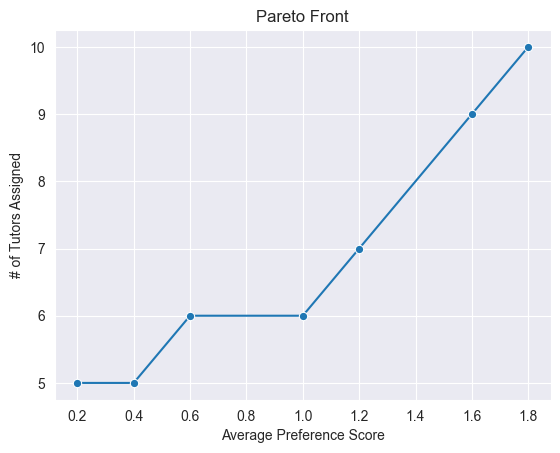

In [5]:
ax = sns.lineplot(x=xa, y=ya, marker="o")
ax.set(xlabel="Average Preference Score", ylabel="# of Tutors Assigned", title='Pareto Front');

This graph shows the Pareto Front of the optimization problem A, which is the set of Pareto efficient solutions where no improvement in one objective can be made without a degradation in the second objective. 

The results show the minimum number of tutors needed for a desired average preference score (0 = no tutors have what they want, 2 = all tutors have their first preference)

# Task B

To balance workload while maximizing tutors' preference on tuition centre.

In [6]:
# may take several minutes to run
score_intervals = np.linspace(0, 2.0, num=8)
xb = []
yb = []
for i in range(len(score_intervals)-1):
    pl = score_intervals[i]
    pu = score_intervals[i+1]
    problem = Problem(ObjectiveType.B, pl, pu)
    if not problem.solve():
        continue
    xb.append(problem.get_preference_score())
    yb.append(problem.get_mad_workload())

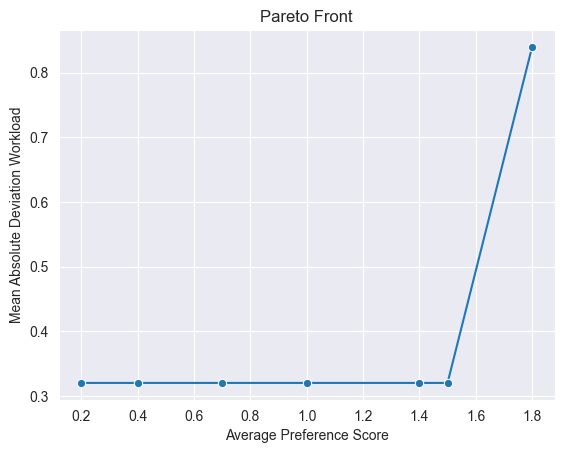

In [7]:
ax = sns.lineplot(x=xb, y=yb, marker="o")
ax.set(xlabel="Average Preference Score", ylabel="Mean Absolute Deviation Workload", title='Pareto Front');

This graph shows the Pareto Front of the optimization problem B. 

The results show that we can achieve a high preference score of 1.5 with maximum work balance amongst the tutors. 